In [ ]:
pip install pygame

In [11]:
import pygame as pg
import numpy as np
from numpy.linalg import norm as Abs
import time
from random import uniform as r
from random import randint as rint
from scipy.constants import g
import matplotlib.pyplot as plt

pg.init()

# Circle properties, disks actually
circle_r_min, circle_r_max = 0.06, 0.06  # m, m
circle_v_min, circle_v_max = 0.01, 0.2  # m/s, m/s
circle_height, circle_density = 0.5, 480  # m, kg/m^3
px_per_m = 750  # Pixel per meter
circle_quantity = 10  # initial number of circles
seizure = True

# Window
win_width, win_height = 1050, 750
win_width_temp, win_height_temp = win_width, win_height
win_width_min, win_height_min = 200, 200
info = pg.display.Info()
win = pg.display.set_mode([win_width, win_height], pg.RESIZABLE)
full = False  # Fullscreen

# Time
time_0 = time.time()  # start time
time_d = time.time() - time_0  # current time

# Gravity
g_toggle = False
g_amp = 1

# Menu
menu = True
font = pg.font.SysFont('trebuchetms', 25)


# Circle
class Circle(object):
    def __init__(self, initPos, pos, rad, v):
        # Physical Properties, no friction considered so no spinning, it makes  it easier to calculate the collisions
        self.pos = np.array(pos)  # position
        self.initPos = np.array(initPos)
        self.r = rad * px_per_m  # radius
        self.v = np.array(v) * px_per_m  # velocity
        self.m = np.pi * rad ** 2 * circle_height * circle_density  # volume of the disk

        # Logic
        self.prev_collision = None

        # Aesthetics
        self.color = (rint(10, 255), rint(10, 255), rint(10, 255)) if seizure else (0, 255, 255)

    def circle_collide(self, circle, circle_v):
        # Physics
        c = circle.pos - self.pos
        v_c = (c[0] * self.v[0] + c[1] * self.v[1]) / (
                c[0] ** 2 + c[
            1] ** 2) * c  # Velocity component in direction of collision / Składowa prędkości w kierunku zderzenia
        v_t = self.v - v_c  # Velocity component tangent to direction of collision / Składowa prędkości styczna do kierunku zderzenia

        circle_c = self.pos - circle.pos
        circle_v_c = (circle_c[0] * circle_v[0] + circle_c[1] * circle_v[1]) / (
                circle_c[0] ** 2 + circle_c[1] ** 2) * circle_c

        # Calculate new velocity in direction of collision while tangent velocity is preserved:
        v_c_new = ((self.m - circle.m) / (self.m + circle.m)) * v_c + (2 * circle.m / (self.m + circle.m)) * circle_v_c
        self.v = v_c_new + v_t

        # Logic
        self.color = (rint(10, 255), rint(10, 255), rint(10, 255)) if seizure else (0, 255, 255)
        self.prev_collision = circle

    def wall_collide(self):
        # Physics
        if self.r > self.pos[0] or self.pos[0] > win_width - self.r:
            self.pos[0] = self.r if self.r > self.pos[0] else win_width - self.r
            self.v[0] = -self.v[0]
            # Logic
            self.prev_collision = None

        if self.r > self.pos[1] or self.pos[1] > win_height - self.r:
            self.pos[1] = self.r if self.r > self.pos[1] else win_height - self.r
            self.v[1] = -self.v[1]
            # Logic
            self.prev_collision = None

    def gravity(self):
        self.v = self.v + np.array([0, g_amp * g]) * time_d * px_per_m

    def move(self):
        self.pos = self.pos + self.v * time_d

    def draw(self):
        draw_pos = np.around(self.pos).astype(int)
        pg.draw.circle(win, self.color, draw_pos, round(self.r))


def rPos():
    return rint(1, win_width), rint(1, win_height)


def rRad():
    return r(circle_r_min, circle_r_max)


def rVel():
    return r(circle_v_min, circle_v_max), r(circle_v_min, circle_v_max)


# Setup
circles = [Circle(rPos(), rPos(), rRad(), rVel()) for i in range(circle_quantity)]
clock = pg.time.Clock()
# Main
run = True
u = 0
collisions_counter = 0
collisions_list = []
collisions_dict = {collisions_counter: time_0}
velocity_dict = {0: time_0}
velocity_list = []
gravity_on_time = 0

while run:

    for event in pg.event.get():
        if event.type == pg.QUIT:
            run = False
        # Keyboard
        elif event.type == pg.KEYDOWN:
            # Circle
            if event.key == pg.K_UP:
                if circle_quantity >= 100:
                    circle_quantity = 100
                    circles = [Circle(rPos(), rPos(), rRad(), rVel()) for i in range(circle_quantity)]
                else:
                    circle_quantity += 1
                    circles = [Circle(rPos(), rPos(), rRad(), rVel()) for i in range(circle_quantity)]
            elif event.key == pg.K_DOWN:
                if circle_quantity <= 0:
                    circle_quantity = 0
                    circles = [Circle(rPos(), rPos(), rRad(), rVel()) for i in range(circle_quantity)]
                else:
                    circle_quantity -= 1
                    circles = [Circle(rPos(), rPos(), rRad(), rVel()) for i in range(circle_quantity)]
            # Gravity
            elif event.key == pg.K_g:
                g_toggle = not g_toggle
                gravity_on_time = time_0
            elif event.key == pg.K_t:
                g_amp = round(g_amp + 0.1, 1)
            elif event.key == pg.K_b:
                g_amp = round(g_amp - 0.1, 1)
            # Aesthetic
            elif event.key == pg.K_c:
                seizure = not seizure
            elif event.key == pg.K_F11:
                full = not full
                if full:
                    win_width_temp, win_height_temp = win_width, win_height
                    win_width, win_height = info.current_w, info.current_h
                    pg.display.set_mode((info.current_w, info.current_h), pg.FULLSCREEN)
                else:
                    win_width, win_height = win_width_temp, win_height_temp
                    pg.display.set_mode([win_width, win_height], pg.RESIZABLE)

        # Window
        elif event.type == pg.VIDEORESIZE and not full:
            win_width, win_height = event.size
            if win_width < win_width_min:
                win_width = win_width_min
            if win_height < win_height_min:
                win_height = win_height_min
            win = pg.display.set_mode([win_width, win_height], pg.RESIZABLE)
            time_d, time_0 = time.time() - time_0, time.time()
            

    # Time
    time_d, time_0 = time.time() - time_0, time.time()
    clock.tick()
        
    
    # Action
    for i, circle_1 in enumerate(circles[:-1]):
        #if gravity_on & collisions_counter > 0:
        #    collisions_counter -= 1
        #    collisions_dict[collisions_counter] = time_0
        #    print("less 1")
        for circle_2 in circles[i + 1:]:
            #if gravity_on & collisions_counter > 0:
            #    collisions_counter -= 1
            #    collisions_dict[collisions_counter] = time_0
            #    print("less 1")
            circle_dist = circle_2.pos - circle_1.pos
            if Abs(circle_dist) <= circle_1.r + circle_2.r:
                if circle_1.prev_collision != circle_2 or circle_2.prev_collision != circle_1:
                    circle_v_1 = circle_1.v
                    circle_1.circle_collide(circle_2, circle_2.v)
                    circle_2.circle_collide(circle_1, circle_v_1)
                    collisions_counter += 1
                    collisions_dict[collisions_counter] = time_0
                    print("collision")
    

                circle_dist_new = circle_dist * (circle_1.r + circle_2.r) / Abs(circle_dist)
                circle_1.pos = circle_1.pos - (circle_dist_new - circle_dist) / 2
                circle_2.pos = circle_2.pos + (circle_dist_new - circle_dist) / 2
                

    for circle in circles:
        circle.wall_collide()
        if g_toggle:
            circle.gravity()

    for circle in circles:
        circle.move()
    
    for circle in circles:
        velocity_dict[np.linalg.norm(circle.v)] = time_0
    

    # Drawing
    win.fill((255, 255, 255))

    for circle in circles:
        circle.draw()
        
        
    if pg.time.get_ticks() >= 250 * u:
        fps_text = font.render("Fps: " + str(int(clock.get_fps())), False, (0, 0, 0))
        u += 1 
        win.blit(fps_text, (win_width - fps_text.get_rect()[2], 0))  
        
    gravity_text = font.render(
        "Switch gravity: " + ("On" if g_toggle else "Off"),
        False, (0, 0, 0))
    win.blit(gravity_text, (0, win_height - font.size("a")[1] * 3))

    circle_text = font.render(
        "Amplify / decrease gravity (t/b): " + str(g_amp),
        False, (0, 0, 0))
    win.blit(circle_text, (0, win_height - font.size("a")[1] * 2))

    circle_text = font.render(
        "Number of circles: " + str(circle_quantity),
        False, (0, 0, 0))
    win.blit(circle_text, (0, win_height - font.size("a")[1] * 1))

    pg.display.update()

pg.quit()


collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision


In [4]:
import matplotlib.pyplot as plt
import numpy as np

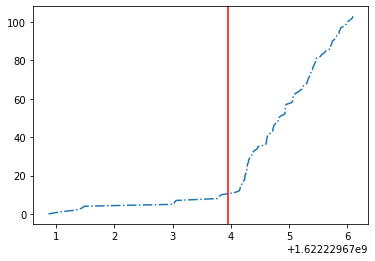

In [12]:
x = np.array(list(collisions_dict.values()))
y = np.array(list(collisions_dict.keys()))

plt.plot(x, y, linestyle='-.')
plt.axvline(x=gravity_on_time, color="red")

In [13]:
vel = list(velocity_dict.keys())
vel_mean = []
for i in range(len(vel)):
    vel[i] = vel[i]
    vel_mean.append(vel[i])

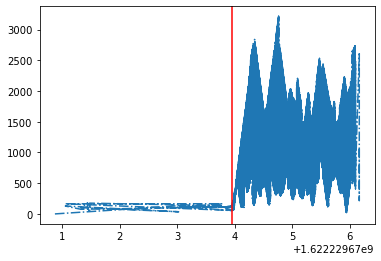

In [14]:
x = np.array(list(velocity_dict.values()))
y = np.array(vel_mean)

plt.plot(x, y, linestyle='-.')
plt.axvline(x=gravity_on_time, color="red")

In [ ]:
#diff = len(mean_square_displacement_list) - len(time_list)
#print(len(mean_square_displacement_list))
#print(diff)
#mean_square_displacement_list = mean_square_displacement_list[diff:]
#print(len(mean_square_displacement_list))


x = np.array(u)
y = np.array(mean_square_displacement_list)
plt.plot(x, linestyle='-.')
#m, b = np.polyfit(x, y, 1)
#plt.plot(x, m * x + b)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

x = np.random.randn(100)
print(x)

df = pd.DataFrame(x, columns=['x'])
df['time'] = np.arange(0,len(df))
df['MSD'] = pd.Series((x - x[0])**2).rolling(window=10, min_periods=1).mean()

x_plt, = plt.plot(x, label='x(t)')
msd_plt, = plt.plot(df['MSD'], label='MSD(t)')
plt.legend(handles=[line_up, line_down])

In [ ]:
## Number of points in the trajectories
n_points = 1000

## Time step between two points
t_step = 1
## Scale of the random movement (standard diviation)
scale = 1.

## 
xy_random = np.random.normal(scale=scale, size=(n_points, 2)).cumsum(axis=0)
xy_random = pd.DataFrame(data=xy_random, 
                         index=pd.Index(np.arange(n_points), name='t_stamp'), columns=['x', 'y'])
xy_random['t'] = np.arange(n_points) * t_step

xy_linear = np.vstack([np.arange(n_points), np.arange(n_points)]).T
xy_linear = pd.DataFrame(data=xy_linear, 
                         index=pd.Index(np.arange(n_points), name='t_stamp'), columns=['x', 'y'])
xy_linear['t'] = np.arange(n_points) * t_step

print(xy_random)